# JOB-A-THON dataset

## Health Insurance Lead Prediction

Your Client FinMan is a financial services company that provides various financial services like loan,investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

    -Demographics (city, age, region etc.)
    -Information regarding holding policies of the customer
    -Recommended Policy Information

In [1]:
## importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
# our evaluation matric
from sklearn.metrics import roc_auc_score
%matplotlib inline

#### Used Tableau and Excel for inital exploration.

    - Did initial value change  from 14+ to 14 on excel for  - Holding_Policy_Duration  

### loading the dataset 

In [2]:
df =pd.read_csv('train.csv')  #train data
df_test = pd.read_csv('test.csv') #test data
df_submit = pd.read_csv('sample_submission_QrCyCoT.csv')  #submission file

In [3]:
data= df.copy()

In [4]:
df.sample(6)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
4112,4113,C2,1419,Rented,Individual,59,59,No,X1,14.0,4.0,14,19140.0,0
40772,40773,C3,1105,Owned,Individual,72,72,No,X2,2.0,1.0,16,27468.0,1
28846,28847,C8,2648,Rented,Individual,18,18,No,X1,NaN,NaN,21,11088.0,0
14583,14584,C2,3369,Owned,Individual,22,22,No,NaN,1.0,4.0,22,8918.0,0
40364,40365,C21,5584,Rented,Individual,23,23,No,X3,NaN,NaN,13,6770.0,1
5263,5264,C9,2005,Owned,Joint,73,47,No,X2,14.0,2.0,17,25494.0,0


## Data validation

In [5]:
# Shape of our dataset - 
df.shape, df_test.shape

((50882, 14), (21805, 13))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  float64
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(3), int64(6

### We have 3 columns with null values- 
    - Health Indicator
    - Holding_Policy_Duration
    - Holding_Policy_Type 

In [7]:
df.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [8]:
df['Holding_Policy_Type'].value_counts()

3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,50882.0,25441.500000,14688.512535,1.0,12721.25,25441.5,38161.75,50882.0
Region_Code,50882.0,1732.788707,1424.081652,1.0,523.00,1391.0,2667.00,6194.0
Upper_Age,50882.0,44.856275,17.310271,18.0,28.00,44.0,59.00,75.0
Lower_Age,50882.0,42.738866,17.319375,16.0,27.00,40.0,57.00,75.0
Holding_Policy_Duration,30631.0,6.015246,4.501648,1.0,2.00,5.0,9.00,14.0
Holding_Policy_Type,30631.0,2.439228,1.025923,1.0,1.00,3.0,3.00,4.0
Reco_Policy_Cat,50882.0,15.115188,6.340663,1.0,12.00,17.0,20.00,22.0
Reco_Policy_Premium,50882.0,14183.950069,6590.074873,2280.0,9248.00,13178.0,18096.00,43350.4
Response,50882.0,0.239947,0.427055,0.0,0.00,0.0,0.00,1.0


###  creating a column to check for new users based on past missing data from the columns

In [10]:
df = df.replace({np.nan: None}) #replacin nan values with None
df_test = df_test.replace({np.nan: None})

In [11]:
# function to check in the columns for users for whom we do not have any past data - they probably will be new users
def conditions(s):
    if (s['Health Indicator'] == None) and (s['Holding_Policy_Duration'] == None) and  (s['Holding_Policy_Type'] == None):
        return 1
    else:
        return 0

In [12]:
df['new_user'] = df.apply(conditions, axis=1)
df_test['new_user'] = df_test.apply(conditions, axis=1)

In [13]:
df['new_user'].nunique()

2

### imputing values for new users in the columns as:

In [14]:
## train data
df.loc[df.new_user == 1, "Health Indicator"] = "X0"
df.loc[df.new_user == 1, "Holding_Policy_Duration"] = 0
df.loc[df.new_user == 1, "Holding_Policy_Type"] = 0

In [15]:
## test data
df_test.loc[df_test.new_user == 1, "Health Indicator"] = "X0"
df_test.loc[df_test.new_user == 1, "Holding_Policy_Duration"] = 0
df_test.loc[df_test.new_user == 1, "Holding_Policy_Type"] = 0

In [16]:
df.isna().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator            7083
Holding_Policy_Duration    15643
Holding_Policy_Type        15643
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
new_user                       0
dtype: int64

In [17]:
#Filling rest of the values as 999

df= df.fillna(999)
df_test= df_test.fillna(999)

In [18]:
df.isna().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
new_user                   0
dtype: int64

All missing values are now imputed

## EDA

In [19]:
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,new_user
0,1,C3,3213,Rented,Individual,36,36,No,X1,14.0,3.0,22,11628.0,0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,999.0,999.0,22,30510.0,0,0
2,3,C5,3732,Owned,Individual,32,32,No,999,1.0,1.0,19,7450.0,1,0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14.0,3.0,19,17780.0,0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0,0


In [20]:
df.corr()  # correlation value

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,new_user
ID,1.000000,-0.000465,-0.001725,0.001101,-0.003939,-0.003893,-0.002235,-0.002350,0.005159,0.004870
Region_Code,-0.000465,1.000000,-0.005649,-0.005928,0.001161,0.001038,-0.065120,-0.010797,0.001121,0.002488
Upper_Age,-0.001725,-0.005649,1.000000,0.921392,-0.233654,-0.235768,0.025257,0.792689,0.002772,-0.110186
Lower_Age,0.001101,-0.005928,0.921392,1.000000,-0.212226,-0.214134,0.021163,0.615739,-0.002099,-0.098120
Holding_Policy_Duration,-0.003939,0.001161,-0.233654,-0.212226,1.000000,0.999969,-0.008491,-0.183501,0.001897,-0.213841
Holding_Policy_Type,-0.003893,0.001038,-0.235768,-0.214134,0.999969,1.000000,-0.008669,-0.185063,0.001767,-0.211704
Reco_Policy_Cat,-0.002235,-0.065120,0.025257,0.021163,-0.008491,-0.008669,1.000000,0.060989,0.114321,-0.009340
Reco_Policy_Premium,-0.002350,-0.010797,0.792689,0.615739,-0.183501,-0.185063,0.060989,1.000000,0.007943,-0.090436
Response,0.005159,0.001121,0.002772,-0.002099,0.001897,0.001767,0.114321,0.007943,1.000000,-0.006042
new_user,0.004870,0.002488,-0.110186,-0.098120,-0.213841,-0.211704,-0.009340,-0.090436,-0.006042,1.000000


In [21]:
# df['av_Age'] = df['av_Age'].map(lambda x:x.astype('int'))
# df_test['av_Age'] = df_test['av_Age'].apply(lambda x:x.astype('int'))


In [22]:
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,new_user
0,1,C3,3213,Rented,Individual,36,36,No,X1,14.0,3.0,22,11628.0,0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,999.0,999.0,22,30510.0,0,0
2,3,C5,3732,Owned,Individual,32,32,No,999,1.0,1.0,19,7450.0,1,0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14.0,3.0,19,17780.0,0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         50882 non-null  object 
 9   Holding_Policy_Duration  50882 non-null  float64
 10  Holding_Policy_Type      50882 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
 14  new_user              

In [24]:
cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health_Indicator','Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat','Response','Top_tier_cities','new_user']
cont_cols = ['av_Age','Age_Bracket', 'Reco_Policy_Premium']

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   City_Code                50882 non-null  object  
 1   Region_Code              50882 non-null  int64   
 2   Accomodation_Type        50882 non-null  object  
 3   Reco_Insurance_Type      50882 non-null  object  
 4   Is_Spouse                50882 non-null  object  
 5   Health Indicator         50882 non-null  object  
 6   Holding_Policy_Duration  50882 non-null  float64 
 7   Holding_Policy_Type      50882 non-null  float64 
 8   Reco_Policy_Cat          50882 non-null  int64   
 9   Reco_Policy_Premium      50882 non-null  float64 
 10  Response                 50882 non-null  int64   
 11  new_user                 50882 non-null  int64   
 12  Age_Bracket              50882 non-null  int64   
 13  AgeBin                   50882 non-null  category
 14  single

## UVA

In [132]:
## cont plot
def plot_cont(var, l=8,b=5):
    plt.figure(figsize=(l, b))
    sns.distplot(df[var])
    plt.xlabel(var)

In [133]:
## cat plot
def plot_cat(var, l=8,b=5):
    plt.figure( figsize = (l, b))
    sns.countplot(df[var], order = df[var].value_counts().index)

In [134]:
#kde plot
def plot_cont_kde(var, l=8,b=5):
    
    mini = data[var].min()
    maxi = data[var].max()
    ran = data[var].max()-data[var].min()
    mean = data[var].mean()
    skew = data[var].skew()
    kurt = data[var].kurtosis()
    median = data[var].median()
    st_dev = data[var].std()
    points = mean-st_dev, mean+st_dev
    
    fig, axes=plt.subplots(1,2)
    sns.boxplot(data=data,x=var, ax=axes[0])
    sns.distplot(a=data[var], ax=axes[1], color='#ff4125')
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini, maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    fig.set_size_inches(l,b)
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median =  {}'.format((round(points[0],2),round(points[1],2)),
    round(kurt,2),round(skew,2),(round(mini,2),round(maxi,2),
    round(ran,2)),round(mean,2), round(median,2)))

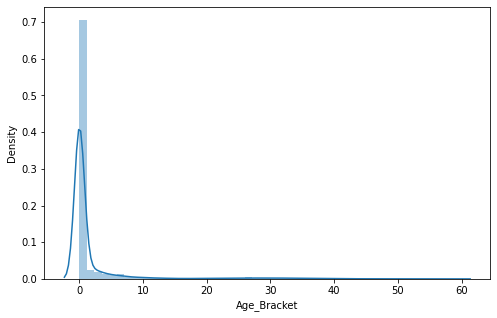

In [137]:
plot_cont('Age_Bracket')

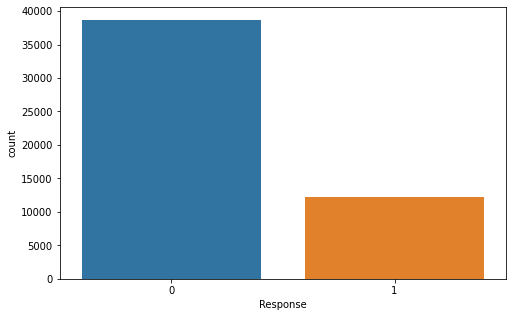

In [138]:
plot_cat('Response')

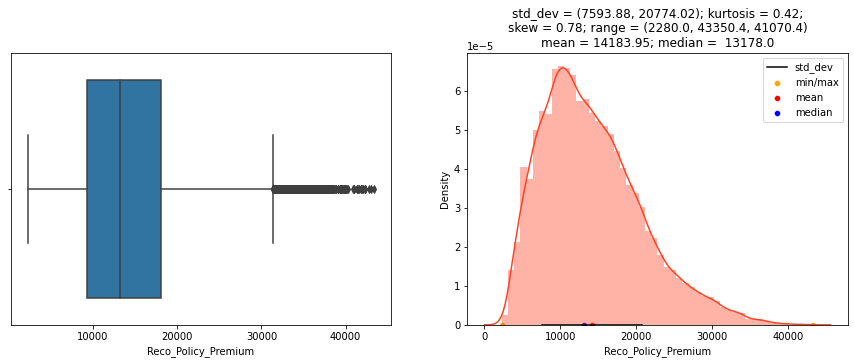

In [139]:
 plot_cont_kde('Reco_Policy_Premium',15,5)

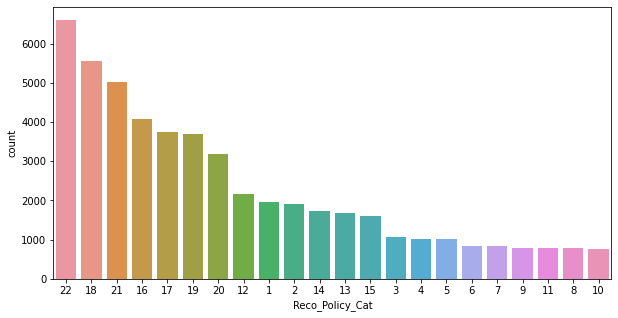

In [140]:
plot_cat('Reco_Policy_Cat',10,5)

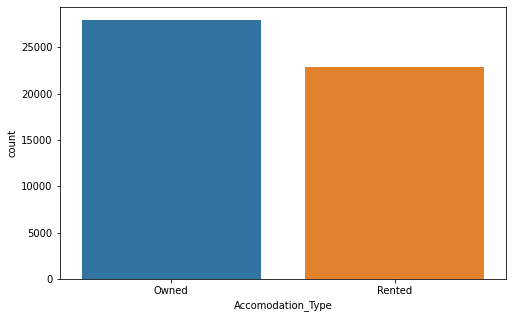

In [141]:
plot_cat('Accomodation_Type')

In [142]:
df['Response'].value_counts(normalize=True)*100

0    76.005267
1    23.994733
Name: Response, dtype: float64

In [143]:
df['Accomodation_Type'].value_counts(normalize=True)

Owned     0.54933
Rented    0.45067
Name: Accomodation_Type, dtype: float64

##  BVA

In [146]:
pd.crosstab(df['Accomodation_Type'], df['Response']).apply(lambda r: r/len(df), axis=1)

Response,0,1
Accomodation_Type,,
Owned,0.416414,0.132915
Rented,0.343638,0.107032


In [147]:
pd.crosstab(df['Is_Spouse'], df['Response']).apply(lambda r: r/len(df), axis=1)

Response,0,1
Is_Spouse,,
No,0.634861,0.199619
Yes,0.125192,0.040329


In [149]:
pd.crosstab(df['City_Code'], df['Response']).apply(lambda r: r/len(df), axis=1)

Response,0,1
City_Code,,
C1,0.132955,0.043395
C10,0.024508,0.007154
C11,0.017059,0.005483
C12,0.013168,0.003891
C13,0.014740,0.005012
C14,0.011202,0.003459
C15,0.018337,0.004972
C16,0.017020,0.005287
C17,0.017570,0.005208


In [150]:
pd.crosstab(df['City_Code'], df['Holding_Policy_Type']).apply(lambda r: r/len(df), axis=1)

Holding_Policy_Type,0.0,1.0,2.0,3.0,4.0,999.0
City_Code,,,,,,
C1,0.014819,0.031288,0.014327,0.047463,0.019791,0.048662
C10,0.002064,0.007232,0.002437,0.007272,0.002575,0.010082
C11,0.002496,0.002909,0.003302,0.005071,0.001415,0.007350
C12,0.001612,0.003832,0.002555,0.003105,0.000688,0.005267
C13,0.002024,0.002457,0.002791,0.004481,0.001376,0.006623
C14,0.001651,0.001906,0.001671,0.003793,0.001395,0.004245
C15,0.001749,0.006328,0.002083,0.005071,0.001435,0.006643
C16,0.001965,0.003302,0.002948,0.004501,0.001042,0.008549
C17,0.002103,0.006545,0.003282,0.002712,0.000924,0.007213


In [151]:
#correlation
cor_mat=df[:].corr()
cor_with_tar=cor_mat.sort_values(['Response'],ascending=False)
cor_with_tar["Response"]

Response                   1.000000
Reco_Policy_Cat            0.114321
Age_Bracket                0.012284
Reco_Policy_Premium        0.007943
Top_tier_cities            0.005305
Holding_Policy_Duration    0.001897
Holding_Policy_Type        0.001767
Region_Code                0.001121
new_user                  -0.006042
single_user               -0.009891
Name: Response, dtype: float64

In [36]:
df.drop(columns = 'ID', inplace=True, axis=1)
df_test.drop(columns = 'ID', inplace=True, axis=1)

In [37]:
## checpoint 1

df_check1 = df.copy()
df_test_check1 = df_test.copy()

# df = df_check1.copy()
# df_test = df_test_check1.copy()

## Feature engineering

### Based on our EDA,

Created features to help our model as:

    - Top_tier_cities

    - new_user

    - AgeBin

    - Age_Bracket
    
    - av_Age
    
    - single_user

In [38]:
#in train 
#creating a column with the age bracket - 
df['Age_Bracket'] = df["Upper_Age"] - df["Lower_Age"]

# as both age columns are highly correlated, aggregating both
col = df.loc[: , "Upper_Age":"Lower_Age"]
df['av_Age'] = np.int64(col.mean(axis=1))
df.sample(5)

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,new_user,Age_Bracket,av_Age
21032,C32,3989,Owned,Individual,44,44,No,X3,999.0,999.0,13,7924.0,1,0,0,44
35081,C18,1449,Rented,Joint,22,21,Yes,X3,999.0,999.0,21,8844.8,0,0,1,21
14648,C2,568,Rented,Individual,57,57,No,999,2.0,2.0,3,14472.0,0,0,0,57
410,C1,1101,Owned,Joint,74,69,Yes,X3,999.0,999.0,19,22458.8,0,0,5,71
6812,C24,2185,Owned,Individual,61,61,No,X1,999.0,999.0,19,20544.0,1,0,0,61


In [39]:
#in test
df_test['Age_Bracket'] = df_test["Upper_Age"] - df_test["Lower_Age"]
col = df_test.loc[: , "Upper_Age":"Lower_Age"]
df_test['av_Age'] = np.int64(col.mean(axis=1))

In [40]:
df = df.drop(columns=['Upper_Age',"Lower_Age"], axis=1)
df_test = df_test.drop(columns=['Upper_Age',"Lower_Age"], axis=1)

In [41]:
df['av_Age'].min(),df['av_Age'].max(), df_test['av_Age'].min(),df_test['av_Age'].max()

(17, 75, 18, 75)

In [42]:
##creating Agebin based on average age
# creating categorical feature from age
bins1 = [16, 29, 39, 49, 55,76]
bins_names = [1, 2, 3, 4, 5]

df['AgeBin'] = pd.cut(df['av_Age'], bins1, labels=bins_names)
df = df.drop(columns=['av_Age'], axis=1)

df_test['AgeBin'] = pd.cut(df_test['av_Age'], bins1, labels=bins_names)
df_test = df_test.drop(columns=['av_Age'], axis=1)

In [43]:
## creating a conditional column for single users using below function - 

def conditions(df):
    if (df['Is_Spouse'] == 'No') and (df['Age_Bracket'] == 0) and  (df['Reco_Insurance_Type'] == 'Individual'):
        return 1
    else:
        return 0

In [44]:
df['single_user'] = df.apply(conditions, axis=1)
df_test['single_user'] = df_test.apply(conditions, axis=1)

In [45]:
##creating a column for top tier cities

top_tier = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12']
df['Top_tier_cities'] = df['City_Code'].apply(lambda x: 1 if x in top_tier else 0)


top_tier = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12']
df_test['Top_tier_cities'] = df_test['City_Code'].apply(lambda x: 1 if x in top_tier else 0)

In [46]:
df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,new_user,Age_Bracket,AgeBin,single_user,Top_tier_cities
0,C3,3213,Rented,Individual,No,X1,14.0,3.0,22,11628.0,0,0,0,2,1,1
1,C5,1117,Owned,Joint,No,X2,999.0,999.0,22,30510.0,0,0,53,3,0,1
2,C5,3732,Owned,Individual,No,999,1.0,1.0,19,7450.0,1,0,0,2,1,1
3,C24,4378,Owned,Joint,No,X1,14.0,3.0,19,17780.0,0,0,4,4,0,0
4,C8,2190,Rented,Individual,No,X2,3.0,1.0,16,10404.0,0,0,0,3,1,1


Response                   1.000000
Reco_Policy_Cat            0.114321
Age_Bracket                0.012284
Reco_Policy_Premium        0.007943
Top_tier_cities            0.005305
Holding_Policy_Duration    0.001897
Holding_Policy_Type        0.001767
Region_Code                0.001121
new_user                  -0.006042
single_user               -0.009891
Name: Response, dtype: float64

## splitting data into train and test

In [48]:
X= df.drop(columns= 'Response',axis=1)
y= df['Response']
X_train ,X_val, y_train ,y_val  = train_test_split(X, y, test_size=0.25, random_state = 7)
col=X_train.columns
X_train.shape ,X_val.shape, y_train.shape ,y_val.shape

((38161, 15), (12721, 15), (38161,), (12721,))

In [49]:
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,new_user,Age_Bracket,AgeBin,single_user,Top_tier_cities
3032,C26,2081,Rented,Joint,Yes,X1,14.0,2.0,1,14756.0,0,9,3,0,0
39927,C4,1106,Rented,Individual,No,X3,2.0,1.0,8,9324.0,0,0,1,1,1
31898,C1,8,Owned,Individual,No,X3,8.0,1.0,5,12546.0,0,0,4,1,1
7278,C23,5881,Owned,Individual,No,X3,999.0,999.0,17,15158.0,0,0,5,1,0
41174,C28,762,Owned,Individual,No,X3,1.0,1.0,19,13700.0,0,0,4,1,0


## outlier mapping

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38161 entries, 3032 to 49689
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   City_Code                38161 non-null  object  
 1   Region_Code              38161 non-null  int64   
 2   Accomodation_Type        38161 non-null  object  
 3   Reco_Insurance_Type      38161 non-null  object  
 4   Is_Spouse                38161 non-null  object  
 5   Health Indicator         38161 non-null  object  
 6   Holding_Policy_Duration  38161 non-null  float64 
 7   Holding_Policy_Type      38161 non-null  float64 
 8   Reco_Policy_Cat          38161 non-null  int64   
 9   Reco_Policy_Premium      38161 non-null  float64 
 10  new_user                 38161 non-null  int64   
 11  Age_Bracket              38161 non-null  int64   
 12  AgeBin                   38161 non-null  category
 13  single_user              38161 non-null  int64   
 14  Top

In [51]:
###  removing outlier values
numeric_col= X_train[["Reco_Policy_Premium"]]
for i in numeric_col:
    X_train.loc[X_train[i]>X_train[i].quantile(0.99),i]=X_train[i].quantile(0.99)

In [52]:
X_train.to_csv('catboost\X_train1.csv',index = False)
X_val.to_csv('catboost\X_val1.csv',index = False)

df_test.to_csv('catboost\df_test1.csv',index = False)

y_train.to_csv('catboost\y_train1.csv',index = False)
y_val.to_csv('catboost\y_val.csv1',index = False)

In [53]:
X_train.sample(10)

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,new_user,Age_Bracket,AgeBin,single_user,Top_tier_cities
37893,C4,4271,Rented,Individual,No,X1,999.0,999.0,22,5176.0,0,0,1,1,1
40371,C18,653,Rented,Individual,No,X1,999.0,999.0,2,3648.0,0,0,1,1,0
31953,C11,319,Rented,Individual,No,X3,3.0,4.0,15,5580.0,0,0,2,1,1
41294,C1,1555,Owned,Individual,No,X1,12.0,4.0,17,15964.0,0,0,5,1,1
22158,C14,3258,Owned,Joint,Yes,999,3.0,2.0,18,19866.0,0,1,5,0,0
2271,C23,5845,Owned,Individual,No,X2,999.0,999.0,14,8800.0,0,0,2,1,0
7189,C16,3754,Owned,Joint,No,X1,5.0,3.0,20,21186.0,0,31,2,0,0
23562,C2,1744,Owned,Individual,No,X4,999.0,999.0,15,6220.0,0,0,1,1,1
26875,C2,746,Rented,Individual,No,X6,6.0,3.0,11,18360.0,0,0,5,1,1
17427,C12,138,Owned,Joint,Yes,X4,3.0,1.0,6,21436.8,0,2,2,0,1


In [54]:
## converting datatype to int
X_train['Holding_Policy_Duration'] = np.int64(X_train['Holding_Policy_Duration'])
X_train['Holding_Policy_Type'] = np.int64(X_train['Holding_Policy_Type'])

X_val['Holding_Policy_Duration'] = np.int64(X_val['Holding_Policy_Duration'])
X_val['Holding_Policy_Type'] = np.int64(X_val['Holding_Policy_Type'])

df_test['Holding_Policy_Duration'] = np.int64(df_test['Holding_Policy_Duration'])
df_test['Holding_Policy_Type'] = np.int64(df_test['Holding_Policy_Type'])

In [55]:
X_train.shape, "----" ,X_val.shape, "-----", df_test.shape

((38161, 15), '----', (12721, 15), '-----', (21805, 15))

In [56]:
X_train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium',
       'new_user', 'Age_Bracket', 'AgeBin', 'single_user', 'Top_tier_cities'],
      dtype='object')

In [57]:
#defining catagorical columns and numerical columns
cat_cols = ['City_Code','Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator','Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat','new_user', 'Top_tier_cities','single_user','AgeBin']
num_cols = ['Age_Bracket','Reco_Policy_Premium']

X_train[cat_cols] = X_train[cat_cols].apply(lambda x: x.astype('category'))
X_train[num_cols] = X_train[num_cols].apply(lambda x: x.astype('int'))

X_val[cat_cols] = X_val[cat_cols].apply(lambda x: x.astype('category'))
X_val[num_cols] = X_val[num_cols].apply(lambda x: x.astype('int'))

df_test[cat_cols] = df_test[cat_cols].apply(lambda x: x.astype('category'))
df_test[num_cols] = df_test[num_cols].apply(lambda x: x.astype('int'))

## Implementing Catboost

In [123]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   City_Code                21805 non-null  category
 1   Region_Code              21805 non-null  category
 2   Accomodation_Type        21805 non-null  category
 3   Reco_Insurance_Type      21805 non-null  category
 4   Is_Spouse                21805 non-null  category
 5   Health Indicator         21805 non-null  category
 6   Holding_Policy_Duration  21805 non-null  category
 7   Holding_Policy_Type      21805 non-null  category
 8   Reco_Policy_Cat          21805 non-null  category
 9   Reco_Policy_Premium      21805 non-null  int32   
 10  new_user                 21805 non-null  category
 11  Age_Bracket              21805 non-null  int32   
 12  AgeBin                   21805 non-null  category
 13  single_user              21805 non-null  category
 14  Top_ti

In [59]:
catcols = ['City_Code','Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator','Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat','new_user', 'Top_tier_cities','single_user','AgeBin']

In [60]:
##importing catboost classifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
model=CatBoostClassifier()

In [61]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
# defining parameters to feed into random search
parameter_grid = {
          'max_depth':[3,1,2,5,7,9,10],
          'iterations':[500,750,1000,1500],
          'learning_rate':[0.001,0.05,0.03,0.01,0.1,0.3], 
          'l2_leaf_reg':[0,3,1,5,10,100],
          'bagging_temperature':[0,1],
          'random_strength':[0,1,3,5]
          }

In [63]:
model1=CatBoostClassifier(cat_features=catcols)

In [64]:
randomsearch=RandomizedSearchCV(model1,param_distributions=parameter_grid,verbose=2,n_iter=3,cv=3)

In [65]:
randomsearch.fit(X_train, y_train)

ning: 1m 21s
118:	learn: 0.4439606	total: 25.4s	remaining: 1m 21s
119:	learn: 0.4439591	total: 25.6s	remaining: 1m 20s
120:	learn: 0.4439591	total: 25.6s	remaining: 1m 20s
121:	learn: 0.4437938	total: 25.8s	remaining: 1m 20s
122:	learn: 0.4437937	total: 25.9s	remaining: 1m 19s
123:	learn: 0.4437448	total: 26.1s	remaining: 1m 19s
124:	learn: 0.4437448	total: 26.1s	remaining: 1m 18s
125:	learn: 0.4435592	total: 26.5s	remaining: 1m 18s
126:	learn: 0.4434675	total: 26.7s	remaining: 1m 18s
127:	learn: 0.4431893	total: 27s	remaining: 1m 18s
128:	learn: 0.4429801	total: 27.3s	remaining: 1m 18s
129:	learn: 0.4427824	total: 27.8s	remaining: 1m 18s
130:	learn: 0.4425561	total: 28s	remaining: 1m 18s
131:	learn: 0.4425387	total: 28.1s	remaining: 1m 18s
132:	learn: 0.4425315	total: 28.1s	remaining: 1m 17s
133:	learn: 0.4424692	total: 28.4s	remaining: 1m 17s
134:	learn: 0.4424129	total: 28.7s	remaining: 1m 17s
135:	learn: 0.4424129	total: 28.7s	remaining: 1m 16s
136:	learn: 0.4424104	total: 28.8s	re

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000020872E54F70>,
                   n_iter=3,
                   param_distributions={'bagging_temperature': [0, 1],
                                        'iterations': [500, 750, 1000, 1500],
                                        'l2_leaf_reg': [0, 3, 1, 5, 10, 100],
                                        'learning_rate': [0.001, 0.05, 0.03,
                                                          0.01, 0.1, 0.3],
                                        'max_depth': [3, 1, 2, 5, 7, 9, 10],
                                        'random_strength': [0, 1, 3, 5]},
                   verbose=2)

In [66]:
randomsearch.best_params_   ## best parameters from random search 

{'random_strength': 3,
 'max_depth': 9,
 'learning_rate': 0.05,
 'l2_leaf_reg': 10,
 'iterations': 500,
 'bagging_temperature': 0}

In [67]:
model3=CatBoostClassifier(random_strength=3,
  max_depth=9,
  learning_rate= 0.05,
  l2_leaf_reg= 10,
  iterations= 500,
  bagging_temperature=0)

In [68]:
model3.fit(X_train,y_train,cat_features=catcols)

learn: 0.4439606	total: 26.6s	remaining: 1m 25s
119:	learn: 0.4439591	total: 26.7s	remaining: 1m 24s
120:	learn: 0.4439591	total: 26.7s	remaining: 1m 23s
121:	learn: 0.4437938	total: 27s	remaining: 1m 23s
122:	learn: 0.4437937	total: 27.1s	remaining: 1m 22s
123:	learn: 0.4437448	total: 27.3s	remaining: 1m 22s
124:	learn: 0.4437448	total: 27.4s	remaining: 1m 22s
125:	learn: 0.4435592	total: 27.6s	remaining: 1m 21s
126:	learn: 0.4434675	total: 27.9s	remaining: 1m 21s
127:	learn: 0.4431893	total: 28.3s	remaining: 1m 22s
128:	learn: 0.4429801	total: 28.6s	remaining: 1m 22s
129:	learn: 0.4427824	total: 28.8s	remaining: 1m 22s
130:	learn: 0.4425561	total: 29.2s	remaining: 1m 22s
131:	learn: 0.4425387	total: 29.3s	remaining: 1m 21s
132:	learn: 0.4425315	total: 29.3s	remaining: 1m 20s
133:	learn: 0.4424692	total: 29.6s	remaining: 1m 20s
134:	learn: 0.4424129	total: 29.9s	remaining: 1m 20s
135:	learn: 0.4424129	total: 29.9s	remaining: 1m 20s
136:	learn: 0.4424104	total: 30s	remaining: 1m 19s
13

In [69]:
prediction1=model3.predict_proba(X_val)

In [71]:
prediction12 = prediction1[:,1]

In [72]:
auc_lr1h =  roc_auc_score(y_val,prediction12)
auc_lr1h

0.7960603452549764

In [80]:
prediction12 = np.array(prediction12)

<AxesSubplot:ylabel='Density'>

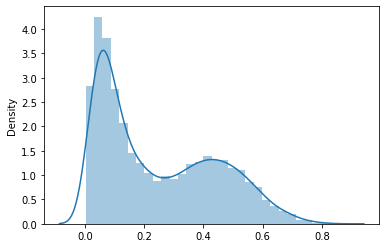

In [82]:
sns.distplot(prediction12)

### Building confusion matrix

In [75]:
# function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [96]:
# creating threshold
val_check=[]
for i in prediction12:
    if i<0.25:
        val_check.append(0)
    else:
        val_check.append(1)

### Score checked for various threshold values of the predicted probability

In [97]:
# calculating ROC score on validation data

auc_lr1h =  roc_auc_score(y_val,val_check)
auc_lr1h

0.739528816095664

Confusion matrix, without normalization
[[6629  650]
 [2994 2448]]


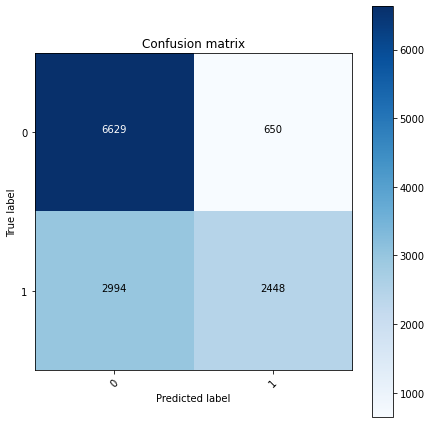

In [98]:
# y_hat_test = lr.predict(X_val_encoded)
cnf_matrix = confusion_matrix(val_check, y_val)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [125]:
tsprediction1=model3.predict_proba(df_test)  # predicted outcome on test data
tsprediction12 = tsprediction1[:,1]

In [126]:
tsprediction12 = np.array(tsprediction12)

### predicted outcome on test data

In [145]:
tsprediction12

array([0.0499322 , 0.10325491, 0.36351855, ..., 0.03107598, 0.54217572,
       0.10776228])

In [127]:
df_submit.shape

(21805, 2)

In [128]:
dict={'ID':df_submit["ID"],'Response':tsprediction12}
df_submit=pd.DataFrame(dict)
df_submit.to_csv('catboost_f1.csv',index=False)

## Feature selection

### More machine learning models

## encoding

In [105]:
X_train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium',
       'new_user', 'Age_Bracket', 'AgeBin', 'single_user', 'Top_tier_cities'],
      dtype='object')

In [106]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38161 entries, 3032 to 49689
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   City_Code                38161 non-null  category
 1   Region_Code              38161 non-null  category
 2   Accomodation_Type        38161 non-null  category
 3   Reco_Insurance_Type      38161 non-null  category
 4   Is_Spouse                38161 non-null  category
 5   Health Indicator         38161 non-null  category
 6   Holding_Policy_Duration  38161 non-null  category
 7   Holding_Policy_Type      38161 non-null  category
 8   Reco_Policy_Cat          38161 non-null  category
 9   Reco_Policy_Premium      38161 non-null  int32   
 10  new_user                 38161 non-null  category
 11  Age_Bracket              38161 non-null  int32   
 12  AgeBin                   38161 non-null  category
 13  single_user              38161 non-null  category
 14  Top

In [107]:
train_X = X_train.copy()
train_y = y_train.copy()
val_X = X_val.copy()
val_y = y_val.copy()

test_df =df_test.copy()

In [108]:
#label encode 
from sklearn import preprocessing 
  # label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

train_X['City_Code'] = label_encoder.fit_transform(train_X['City_Code'])
val_X['City_Code'] = label_encoder.transform(val_X['City_Code'])
test_df['City_Code'] = label_encoder.transform(test_df['City_Code'])

train_X['AgeBin'] = label_encoder.fit_transform(train_X['AgeBin'])
val_X['AgeBin'] = label_encoder.transform(val_X['AgeBin'])
test_df['AgeBin'] = label_encoder.transform(test_df['AgeBin'])

train_X['Reco_Insurance_Type'] = label_encoder.fit_transform(train_X['Reco_Insurance_Type'])
val_X['Reco_Insurance_Type'] = label_encoder.transform(val_X['Reco_Insurance_Type'])
test_df['Reco_Insurance_Type'] = label_encoder.transform(test_df['Reco_Insurance_Type'])

In [111]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38161 entries, 3032 to 49689
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   City_Code                38161 non-null  int32   
 1   Region_Code              38161 non-null  int64   
 2   Accomodation_Type        38161 non-null  category
 3   Reco_Insurance_Type      38161 non-null  int32   
 4   Is_Spouse                38161 non-null  category
 5   Health Indicator         38161 non-null  category
 6   Holding_Policy_Duration  38161 non-null  category
 7   Holding_Policy_Type      38161 non-null  category
 8   Reco_Policy_Cat          38161 non-null  category
 9   Reco_Policy_Premium      38161 non-null  int32   
 10  new_user                 38161 non-null  category
 11  Age_Bracket              38161 non-null  int32   
 12  AgeBin                   38161 non-null  int64   
 13  single_user              38161 non-null  category
 14  Top

In [112]:
train_X[''] = train_X['Region_Code'].astype('int')
val_X['Region_Code'] = val_X['Region_Code'].astype('int')
test_df['Region_Code'] = test_df['Region_Code'].astype('int')

In [113]:
# one-hot encode

cat = ['Accomodation_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Top_tier_cities', 'AgeBin','single_user', 'new_user']
X_train_encoded = pd.get_dummies(data=train_X, columns= cat, prefix_sep = '_', drop_first=True)

X_val_encoded = pd.get_dummies(data=val_X, columns= cat, prefix_sep = '_', drop_first=True)
df_test_encoded = pd.get_dummies(data=test_df, columns= cat, prefix_sep = '_', drop_first=True)

In [114]:
X_train_encoded.head(10)

,City_Code,Region_Code,Reco_Insurance_Type,Reco_Policy_Premium,Age_Bracket,,Accomodation_Type_Rented,Is_Spouse_Yes,Health Indicator_X0,Health Indicator_X1,...,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Top_tier_cities_1,AgeBin_1,AgeBin_2,AgeBin_3,AgeBin_4,single_user_1,new_user_1
3032,18,1770,1,14756,9,1770,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
39927,30,923,0,9324,0,923,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
31898,0,6,0,12546,0,6,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
7278,15,4969,0,15158,0,4969,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
41174,20,616,0,13700,0,616,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
15003,33,562,0,17394,0,562,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
17197,11,1565,0,12870,0,1565,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
12252,30,802,1,24486,4,802,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
40891,1,1415,0,14856,0,1415,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
7772,11,740,0,16008,0,740,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0


In [115]:
X_val_encoded.shape, X_train_encoded.shape

((12721, 65), (38161, 66))

## RF

In [116]:
from sklearn.ensemble import RandomForestClassifier as RF

In [129]:
clf=RF(max_depth=3,n_estimators=1000)
clf.fit(X_train_encoded,train_y)
# rf_res=clf.predict(X_val_encoded)

In [115]:
X_train['Health Indicator'].unique()

array(['X1', 'X3', 'X2', 'X4', 'X0', 'X6', 'X8', 'X7', 'X5', 'X9'],
      dtype=object)

In [221]:
# df['Health Indicator'] = df['Health Indicator'].fillna('X0')
# df['Holding_Policy_Duration']= df['Holding_Policy_Duration'].fillna(14)
# df['Holding_Policy_Type'] = df['Holding_Policy_Type'].fillna(0)

In [226]:
# #test data

# df_test['Health Indicator'] = df_test['Health Indicator'].fillna('X0')
# df_test['Holding_Policy_Duration']= df_test['Holding_Policy_Duration'].fillna(14)
# df_test['Holding_Policy_Type'] = df_test['Holding_Policy_Type'].fillna(0)

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       50882 non-null  int64   
 1   City_Code                50882 non-null  object  
 2   Region_Code              50882 non-null  int64   
 3   Accomodation_Type        50882 non-null  object  
 4   Reco_Insurance_Type      50882 non-null  object  
 5   Is_Spouse                50882 non-null  object  
 6   Health Indicator         50882 non-null  object  
 7   Holding_Policy_Duration  50882 non-null  float64 
 8   Holding_Policy_Type      50882 non-null  float64 
 9   Reco_Policy_Cat          50882 non-null  int64   
 10  Reco_Policy_Premium      50882 non-null  float64 
 11  Response                 50882 non-null  int64   
 12  AgeBin                   50882 non-null  category
dtypes: category(1), float64(3), int64(4), object(5)
memory usage:

In [228]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       21805 non-null  int64   
 1   City_Code                21805 non-null  object  
 2   Region_Code              21805 non-null  int64   
 3   Accomodation_Type        21805 non-null  object  
 4   Reco_Insurance_Type      21805 non-null  object  
 5   Is_Spouse                21805 non-null  object  
 6   Health Indicator         21805 non-null  object  
 7   Holding_Policy_Duration  21805 non-null  float64 
 8   Holding_Policy_Type      21805 non-null  float64 
 9   Reco_Policy_Cat          21805 non-null  int64   
 10  Reco_Policy_Premium      21805 non-null  float64 
 11  AgeBin                   21805 non-null  category
dtypes: category(1), float64(3), int64(3), object(5)
memory usage: 1.9+ MB


## Using Logistic regression

In [116]:
#Applying logreg
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.metrics import roc_auc_score

In [130]:
lr = logreg(class_weight='balanced')

lr.fit(X_train_encoded, y_train)

lr_train_predict = lr.predict_proba(X_train_encoded)

lr_test_predict = lr.predict_proba(X_val_encoded)

In [158]:
xpred =lr_train_predict[:,-1]
ypred =lr_test_predict[:,-1]

In [159]:
auc_lr1 =  roc_auc_score(y_train,xpred)
auc_lr1

0.6261606017654511

### decision tree

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': list(range(2, 10)),'max_leaf_nodes': list(range(1, 100)), 'min_samples_split': [2,3,4,5]}

random_search_cv = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3, n_jobs=-1)

random_search_cv.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.9s finished


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, ...],
                                        'min_samples_split': [2, 3, 4, 5]},
                   verbose=1)

In [161]:
random_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=61, random_state=42)

In [162]:
dt1 = DecisionTreeClassifier( max_depth=5, max_leaf_nodes=61, random_state=42)

In [163]:
#fitting the model
dt1.fit(X_train_encoded, y_train)
pred_train = dt1.predict_proba(X_train_encoded)
pred_val = dt1.predict_proba(X_val_encoded)
# pred_test = dt1.predict_proba(test)


In [164]:
pred_val[:,-1].min(),pred_val[:,-1].max()

(0.0, 0.8888888888888888)

In [165]:
xpred1=pred_train[:,-1]
ypred1 = pred_val[:,-1]

In [166]:
auc_dtt =  roc_auc_score(y_train,xpred1)
auc_dtt

0.5929850603316413

In [167]:
#calculating roc_auc_score for xgboost
auc_dt =  roc_auc_score(y_val,ypred1)
auc_dt

0.5891649062489958

In [177]:
pred_test = dt1.predict_proba(df_test_encoded)[:,1]

In [178]:
pred_test.min(),pred_test.max()

(0.0, 0.8888888888888888)

In [179]:
pred_test

array([0.19457999, 0.19457999, 0.28814554, ..., 0.19457999, 0.28221979,
       0.19457999])

In [180]:
pred_test = np.array(pred_test)

<AxesSubplot:ylabel='Density'>

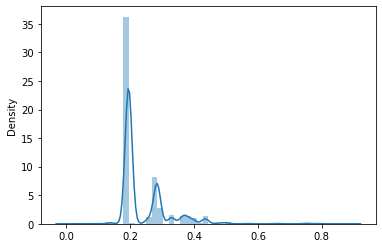

In [181]:
sns.distplot(pred_test)

In [182]:
test_submit1=[]
for i in pred_test:
    if i<0.5:
        test_submit1.append(0)
    else:
        test_submit1.append(1)

In [184]:
test_submit1=np.array(test_submit1)
test_submit1.shape

(21805,)

In [186]:
df_submit = pd.read_csv('sample_submission_QrCyCoT.csv',index_col = None)

In [188]:
dict={'ID':df_submit["ID"],'Response':test_submit1}
df_submit=pd.DataFrame(dict)
df_submit.to_csv('dt1.csv',index=False)

In [191]:
df_submit['Response'].value_counts()

0    21547
1      258
Name: Response, dtype: int64

# Applying lgbm

In [197]:
from pandas import Series, DataFrame 
from datetime import datetime
#import lightgbm
import lightgbm as lgb 
import xgboost as xgb
import datetime

In [198]:
train_data=lgb.Dataset(X_train_encoded,label=y_train)

In [199]:
#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

#Here we have set max_depth in xgb and LightGBM to 7 to have a fair comparison between the two.

In [200]:
#training our model using light gbm

num_round=50
lgbm=lgb.train(param,train_data,num_round)


ValueError: Series.dtypes must be int, float or bool

In [259]:
xpred2=lgbm.predict(X_train_encoded)
#predicting on test set
ypred2=lgbm.predict(X_val_encoded)
ypred2[0:5],xpred2[0:5]

(array([0.34066567, 0.13633306, 0.29855903, 0.12955475, 0.40474291]),
 array([0.01947293, 0.11574253, 0.11109438, 0.34199241, 0.28429385]))

In [260]:
auc_lgb1 =  roc_auc_score(y_train,xpred2)
auc_lgb1

0.7065847547488038

In [269]:
ypred3=lgbm.predict(df_test_encoded)

In [271]:
ypred3

array([0.30082134, 0.26435779, 0.26145602, ..., 0.06093641, 0.2715163 ,
       0.22385874])

In [272]:
ypred3.min(),ypred3.max()

(0.019124163166877865, 0.5508152274963309)

In [270]:
df_submit

,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0
...,...,...
21800,72683,0
21801,72684,0
21802,72685,0
21803,72686,0


## Applying xgboost

In [261]:
#The data is stored in a DMatrix object 
#label is used to define our outcome variable
dtrain=xgb.DMatrix(X_train_encoded,label=y_train)
dtest=xgb.DMatrix(X_val_encoded)

In [262]:
# dtest1=xgb.DMatrix(test)

In [263]:
#setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [264]:
#training our model 
num_round=50
 
xg1=xgb.train(parameters,dtrain,num_round) 


[08:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [265]:
xpred3=xg1.predict(dtrain) 
ypred3=xg1.predict(dtest) 
ypred3, xpred3

(array([0.361531  , 0.14934531, 0.32559824, ..., 0.28739503, 0.27146405,
        0.29766655], dtype=float32),
 array([0.04333771, 0.13101424, 0.12404616, ..., 0.21275556, 0.29013   ,
        0.2629443 ], dtype=float32))

In [266]:

auc_xgb =  roc_auc_score(y_val,ypred3)
auc_xgb

0.6607246350754631